<a href="https://colab.research.google.com/github/gabrielecola/Blood-Cells-Cancer/blob/main/Blood_Cancer_Project__GabrieleCola.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Import Packages

In [ ]:
# modules for importing
from pathlib import Path
import os.path
import pandas as pd
import numpy as np

# modules for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

# modules of Py-Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

# modules for metrics
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay

## 1. Import Dataset

**Introduction to the Problem** \
The definitive diagnosis of Acute Lymphoblastic Leukemia (ALL), as a highly prevalent cancer, requires invasive, expensive, and time-consuming diagnostic tests. ALL diagnosis using peripheral blood smear (PBS) images plays a vital role in the initial screening of cancer from non-cancer cases.  \
The examination of these PBS images by laboratory users is riddled with problems such as diagnostic error because the non-specific nature of ALL signs and symptoms often leads to misdiagnosis. \

**Introduction to the [Dataset](https://www.kaggle.com/datasets/mohammadamireshraghi/blood-cell-cancer-all-4class)**\
 This **dataset** consisted of **3242** PBS images from **89** patients suspected of ALL, whose blood samples were prepared and stained by skilled laboratory staff. \
This dataset is divided into two classes benign and malignant. The former comprises hematogenous, and the latter is the ALL group with three subtypes of malignant lymphoblasts:
- Benign 
- Malignant Early Pre-B 
- Malignant Pre-B 
- Malignant Pro-B 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = "/content/drive/MyDrive/Blood_cell_Cancer"

In [ ]:
image_dir = Path(data)

# obtain the file path
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) 

# obtain the labels
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/Blood_cell_Cancer/[Mali...,[Malignant] Pro-B
1,/content/drive/MyDrive/Blood_cell_Cancer/[Mali...,[Malignant] Pro-B
2,/content/drive/MyDrive/Blood_cell_Cancer/[Mali...,[Malignant] Pro-B
3,/content/drive/MyDrive/Blood_cell_Cancer/[Mali...,[Malignant] Pro-B
4,/content/drive/MyDrive/Blood_cell_Cancer/[Mali...,[Malignant] Pro-B
...,...,...
3237,/content/drive/MyDrive/Blood_cell_Cancer/Benig...,Benign
3238,/content/drive/MyDrive/Blood_cell_Cancer/Benig...,Benign
3239,/content/drive/MyDrive/Blood_cell_Cancer/Benig...,Benign
3240,/content/drive/MyDrive/Blood_cell_Cancer/Benig...,Benign


In [ ]:
# here we show the count for each class
image_df['Label'].value_counts()

[Malignant] early Pre-B    979
[Malignant] Pre-B          955
[Malignant] Pro-B          796
Benign                     512
Name: Label, dtype: int64

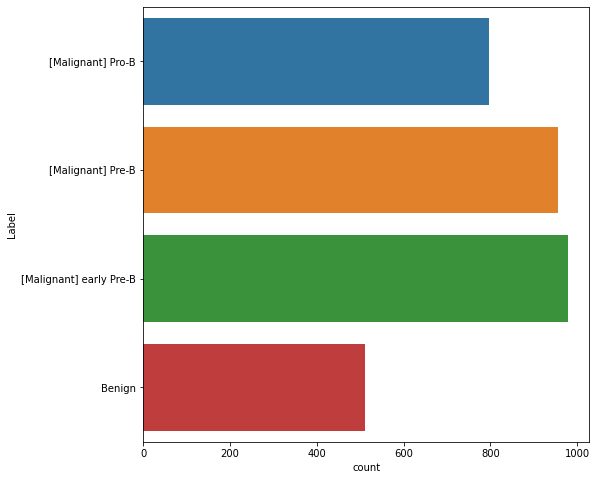

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(y='Label', data=image_df)
plt.show()

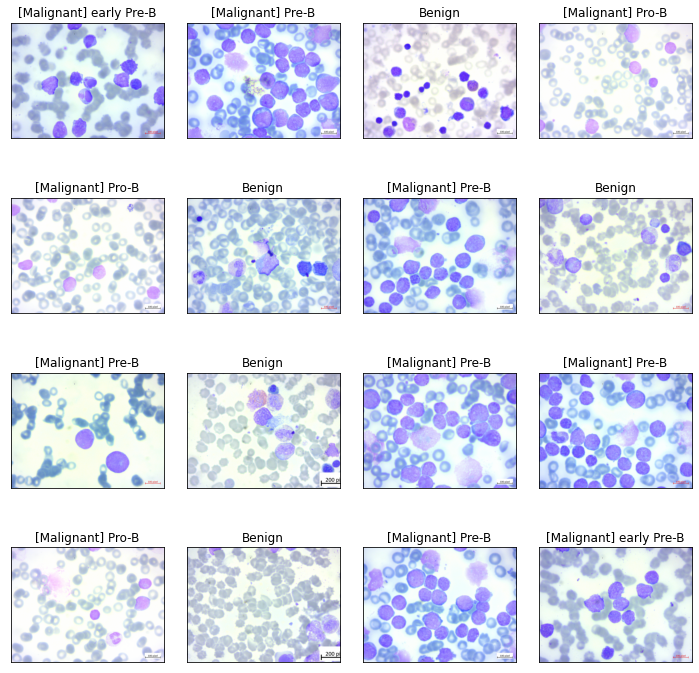

In [ ]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

## 2. Transform the Dataset

In [ ]:
def load_dataset(data_path):
    # Transform images 
    transformation = transforms.Compose([
        # Resize images according to AlexNet and VGG
        transforms.Resize((224, 224)),
        # Transform images in a tensor
        transforms.ToTensor()
    ])

    # Load all of the images and  transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training 70%, valid 15%, test 15%
    # 2270 is equal to 70% of 3242 images(the overall dataset) etc..
    # use torch.utils.data.random_split for training/valid/ test split
    train_dataset,valid_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [2270,486, 486])
    
    # define a loader for the training data 
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=True
    )

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=8,
        shuffle=True
    )
    
    # define a loader for the testing data 
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=8,
        num_workers=2,
        shuffle=True
    )
        
    return train_loader,valid_loader, test_loader

In [ ]:
train_folder = '/content/drive/MyDrive/Blood_cell_Cancer'

# Get the iterative dataloaders for train, valid, test data
train_loader,valid_loader, test_loader = load_dataset(train_folder)

## 3. CNN

### 3.1 Alex Net 



<img src="https://user-images.githubusercontent.com/103529789/205614977-97f9f711-49e8-4a60-b77e-1cb0240d8878.png" height='200' width="500"/>

In [ ]:
class Alexnet(nn.Module):
    def __init__(self):
        super(Alexnet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=256 * 6 * 6, out_features=4096)
        self.fc2 = nn.Linear(in_features=4096, out_features=4096)
        self.fc3 = nn.Linear(in_features=4096, out_features=4)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2)
        # This layer helps us avoid calculating output map size when feeding into a linear layer in PyTorch.
        self.adaptive_pool = nn.AdaptiveAvgPool2d(output_size=(6, 6))
        self.norm = nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=1.0)
        self.dropout = nn.Dropout()
    
    def forward(self, x):
        x = self.max_pool(self.norm(F.relu(self.conv1(x))))
        x = self.max_pool(self.norm(F.relu(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.adaptive_pool(self.norm(F.relu(self.conv5(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
if __name__ == '__main__':
    
    LEARNING_RATE = 0.0001
    BATCH_SIZE = 8
    EPOCHS = 10
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    alexnet = Alexnet() #  On CPU
    alexnet.to(device) # On GPU
    criterion = nn.CrossEntropyLoss() # Specify the loss criteria
    optimizer = optim.Adam(alexnet.parameters(), lr=LEARNING_RATE) # Use an "Adam" optimizer to adjust weights
    train_accuracy= []
    train_loss= []
    valid_accuracy=[]
    valid_loss=[]
    data, targets = next(iter(train_loader))
    for epoch in tqdm(range(EPOCHS)):
        print("Epoch {} ".format(epoch))
        num_correct = 0
        num_samples = 0
        running_loss = 0
        # Set the model to training mode
        alexnet.train()
        with tqdm(total=len(train_loader)) as pbar:
            for batch_idx, (data, targets) in enumerate(train_loader):
                data = data.to(device=device)
                targets = targets.to(device=device)
                
                # Reset the optimizer
                optimizer.zero_grad()

                scores = alexnet(data)
                _, predictions = scores.max(1)

                # Get the loss
                loss = criterion(scores, targets)
                running_loss += loss.item()

                num_correct += (predictions == targets).sum()
                num_samples += predictions.size(0)

                # backpropagation
                loss.backward()
                optimizer.step()
                pbar.update(1)
        print("Correct: {}, Total: {}, Train Accuracy: {}, Train Loss:{}".format(num_correct, num_samples, int(num_correct) / int(num_samples),running_loss/len(train_loader)))
        train_accuracy.append(int(num_correct) / int(num_samples))
        train_loss.append(running_loss/len(train_loader))

        num_correct_valid = 0
        num_samples_valid = 0
        batch_loss = 0
        # Switch the model to evaluation mode (so we don't backpropagate or drop)
        alexnet.eval()
        with torch.no_grad():
         for dataa, targetss in tqdm(valid_loader):
            dataa = dataa.to(device)
            targetss = targetss.to(device)
            scoress = alexnet(dataa)
            _, predictionss = scoress.max(1)
            loss_valid = criterion(scoress, targetss)
            batch_loss += loss_valid.item()
            num_correct_valid += (predictionss == targetss).sum()
            num_samples_valid += predictionss.size(0)
        print("Correct: {}, Total: {}, Valid Accuracy: {}, Valid Loss:{}".format(num_correct_valid, num_samples_valid, int(num_correct_valid) / int(num_samples_valid),batch_loss/len(valid_loader)))
        valid_accuracy.append(int(num_correct_valid) / int(num_samples_valid))
        valid_loss.append(batch_loss/len(valid_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 


  0%|          | 0/284 [00:00<?, ?it/s]

Correct: 733, Total: 2270, Train Accuracy: 0.3229074889867841, Train Loss:1.3380611847404023


  0%|          | 0/61 [00:00<?, ?it/s]

Correct: 260, Total: 486, Valid Accuracy: 0.5349794238683128, Valid Loss:1.3010964921263397
Epoch 1 


  0%|          | 0/284 [00:00<?, ?it/s]

Correct: 1536, Total: 2270, Train Accuracy: 0.6766519823788546, Train Loss:0.7753530593562714


  0%|          | 0/61 [00:00<?, ?it/s]

Correct: 343, Total: 486, Valid Accuracy: 0.7057613168724279, Valid Loss:0.6474493434194659
Epoch 2 


  0%|          | 0/284 [00:00<?, ?it/s]

Correct: 1721, Total: 2270, Train Accuracy: 0.7581497797356829, Train Loss:0.5937427800201195


  0%|          | 0/61 [00:00<?, ?it/s]

Correct: 373, Total: 486, Valid Accuracy: 0.7674897119341564, Valid Loss:0.5474265281294213
Epoch 3 


  0%|          | 0/284 [00:00<?, ?it/s]

Correct: 1735, Total: 2270, Train Accuracy: 0.76431718061674, Train Loss:0.5579139480341069


  0%|          | 0/61 [00:00<?, ?it/s]

Correct: 378, Total: 486, Valid Accuracy: 0.7777777777777778, Valid Loss:0.5134618091778677
Epoch 4 


  0%|          | 0/284 [00:00<?, ?it/s]

Correct: 1766, Total: 2270, Train Accuracy: 0.7779735682819383, Train Loss:0.47595676111260715


  0%|          | 0/61 [00:00<?, ?it/s]

Correct: 384, Total: 486, Valid Accuracy: 0.7901234567901234, Valid Loss:0.4606787669854086
Epoch 5 


  0%|          | 0/284 [00:00<?, ?it/s]

Correct: 1821, Total: 2270, Train Accuracy: 0.8022026431718061, Train Loss:0.44499128755234496


  0%|          | 0/61 [00:00<?, ?it/s]

Correct: 396, Total: 486, Valid Accuracy: 0.8148148148148148, Valid Loss:0.3993619753078359
Epoch 6 


  0%|          | 0/284 [00:00<?, ?it/s]

Correct: 1884, Total: 2270, Train Accuracy: 0.8299559471365638, Train Loss:0.38010708540292704


  0%|          | 0/61 [00:00<?, ?it/s]

Correct: 398, Total: 486, Valid Accuracy: 0.8189300411522634, Valid Loss:0.39775695456344573
Epoch 7 


  0%|          | 0/284 [00:00<?, ?it/s]

Correct: 1924, Total: 2270, Train Accuracy: 0.8475770925110132, Train Loss:0.3397522571965606


  0%|          | 0/61 [00:00<?, ?it/s]

Correct: 380, Total: 486, Valid Accuracy: 0.7818930041152263, Valid Loss:0.5152921249448764
Epoch 8 


  0%|          | 0/284 [00:00<?, ?it/s]

Correct: 2023, Total: 2270, Train Accuracy: 0.8911894273127753, Train Loss:0.28076806627902606


  0%|          | 0/61 [00:00<?, ?it/s]

Correct: 414, Total: 486, Valid Accuracy: 0.8518518518518519, Valid Loss:0.3122435639627644
Epoch 9 


  0%|          | 0/284 [00:00<?, ?it/s]

Correct: 2047, Total: 2270, Train Accuracy: 0.9017621145374449, Train Loss:0.2675247627358005


  0%|          | 0/61 [00:00<?, ?it/s]

Correct: 436, Total: 486, Valid Accuracy: 0.897119341563786, Valid Loss:0.2433657753357633


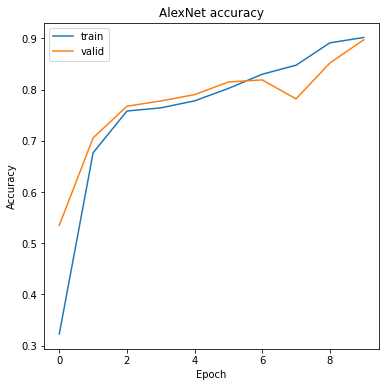

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(train_accuracy)
plt.plot(valid_accuracy)
plt.title('AlexNet accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
plt.savefig('Alexnet_Accuracy.png')

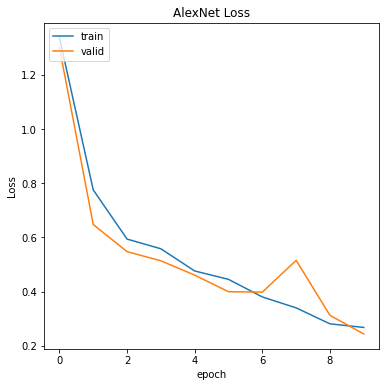

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(train_loss)
plt.plot(valid_loss)
plt.title('AlexNet Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
plt.savefig('Alexnet_Loss.png')

From the two graphs above we can notice that the model in some epochs has a valid accuracy little higher than train accuracy, this perhaps is due to Dropout that make our model so good to generalize when see new data

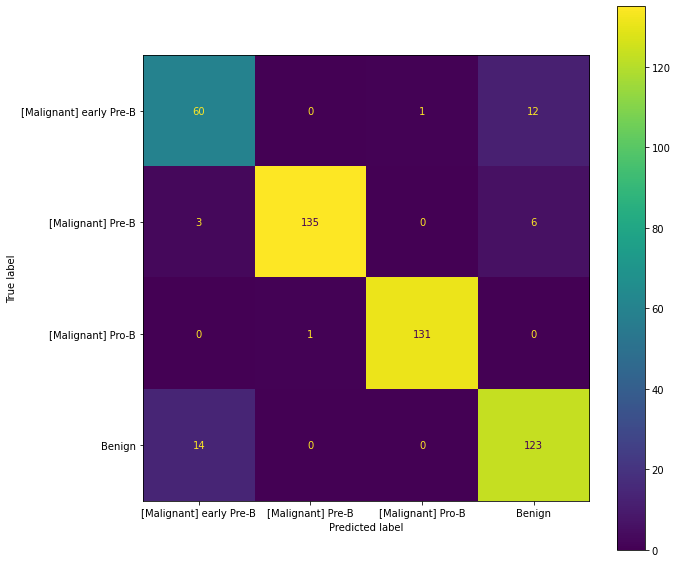

In [ ]:
y_pred = []
y_true = []
# iterate over test data
for inputs, labels in test_loader:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        inputs, labels = inputs.to(device), labels.to(device)
        output = alexnet(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# classes
classes = ('[Malignant] early Pre-B', '[Malignant] Pre-B', '[Malignant] Pro-B', 'Benign')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
cmp=ConfusionMatrixDisplay(cf_matrix, display_labels=classes)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)
plt.show()

From the confusion matrix we can notice that the AlexNet model performs very well, even if there is a little misclassification between Benign and Malignant early Pre-B, but it is understandable because perhaps there is a small difference between a benign and the first stage of cancer.

In [ ]:
print(classification_report(y_true, y_pred, target_names=classes))

                         precision    recall  f1-score   support

[Malignant] early Pre-B       0.78      0.82      0.80        73
      [Malignant] Pre-B       0.99      0.94      0.96       144
      [Malignant] Pro-B       0.99      0.99      0.99       132
                 Benign       0.87      0.90      0.88       137

               accuracy                           0.92       486
              macro avg       0.91      0.91      0.91       486
           weighted avg       0.93      0.92      0.92       486



### 3.2 VGG 16


<img src="https://user-images.githubusercontent.com/103529789/205627662-4bba5773-0eb1-43ea-893c-a72d0ed49390.png" height='300' width="600"/>



In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=4):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
if __name__ == '__main__':
    
    LEARNING_RATE = 0.0001
    BATCH_SIZE = 8
    EPOCHS = 10
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    vgg = VGG16() #  On CPU
    vgg.to(device) # On GPU
    criterion = nn.CrossEntropyLoss()
    optimizer_vgg = optim.Adam(vgg.parameters(), lr=LEARNING_RATE) 
    train_accuracy_vgg= []
    train_loss_vgg= []
    valid_accuracy_vgg=[]
    valid_loss_vgg=[]
    data, targets = next(iter(train_loader))
    for epoch in tqdm(range(EPOCHS)):
        print("Epoch {} ".format(epoch))
        num_correct_vgg = 0
        num_samples_vgg = 0
        running_loss_vgg = 0
        vgg.train()
        with tqdm(total=len(train_loader)) as pbar:
            for batch_idx_vgg, (data_vgg, targets_vgg) in enumerate(train_loader):
                data_vgg = data_vgg.to(device=device)
                targets_vgg = targets_vgg.to(device=device)

                optimizer_vgg.zero_grad()

                scores_vgg = vgg(data_vgg)
                _, predictions_vgg = scores_vgg.max(1)

                loss_vgg = criterion(scores_vgg, targets_vgg)
                running_loss_vgg += loss_vgg.item()

                num_correct_vgg += (predictions_vgg == targets_vgg).sum()
                num_samples_vgg += predictions_vgg.size(0)

                # backprop
                loss_vgg.backward()
                optimizer_vgg.step()
                pbar.update(1)

        print("Correct: {}, Total: {}, Train Accuracy: {}, Train Loss: {}".format(num_correct_vgg, num_samples_vgg, int(num_correct_vgg) / int(num_samples_vgg),running_loss_vgg / len(train_loader)))
        train_accuracy_vgg.append(int(num_correct_vgg) / int(num_samples_vgg))
        train_loss_vgg.append(running_loss_vgg/len(train_loader))

        num_correct_valid_vgg = 0
        num_samples_valid_vgg = 0
        batch_loss_vgg = 0
        vgg.eval()
        with torch.no_grad():
         for dataa_vgg, targetss_vgg in tqdm(valid_loader):
            dataa_vgg = dataa_vgg.to(device)
            targetss_vgg = targetss_vgg.to(device)
            scoress_vgg = vgg(dataa_vgg)
            _, predictionss_vgg = scoress_vgg.max(1)
            loss_valid_vgg = criterion(scoress_vgg, targetss_vgg)
            batch_loss_vgg += loss_valid_vgg.item()
            num_correct_valid_vgg += (predictionss_vgg == targetss_vgg).sum()
            num_samples_valid_vgg += predictionss_vgg.size(0)
        print("Correct: {}, Total: {}, Valid Accuracy: {},Valid Loss: {}".format(num_correct_valid_vgg, num_samples_valid_vgg, int(num_correct_valid_vgg) / int(num_samples_valid_vgg), batch_loss_vgg/len(valid_loader)))
        valid_accuracy_vgg.append(int(num_correct_valid_vgg) / int(num_samples_valid_vgg))
        valid_loss_vgg.append(batch_loss_vgg/len(valid_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 


  0%|          | 0/284 [00:00<?, ?it/s]

Correct: 1787, Total: 2270, Train Accuracy: 0.7872246696035242, Train Loss: 0.6843195073240974


  0%|          | 0/61 [00:00<?, ?it/s]

Correct: 341, Total: 486, Valid Accuracy: 0.7016460905349794,Valid Loss: 1.1828547303916002
Epoch 1 


  0%|          | 0/284 [00:00<?, ?it/s]

Correct: 2030, Total: 2270, Train Accuracy: 0.8942731277533039, Train Loss: 0.30823252604197066


  0%|          | 0/61 [00:00<?, ?it/s]

Correct: 465, Total: 486, Valid Accuracy: 0.9567901234567902,Valid Loss: 0.11273264947736666
Epoch 2 


  0%|          | 0/284 [00:00<?, ?it/s]

Correct: 2107, Total: 2270, Train Accuracy: 0.9281938325991189, Train Loss: 0.25028629419036186


  0%|          | 0/61 [00:00<?, ?it/s]

Correct: 468, Total: 486, Valid Accuracy: 0.9629629629629629,Valid Loss: 0.14173641773398782
Epoch 3 


  0%|          | 0/284 [00:00<?, ?it/s]

Correct: 2121, Total: 2270, Train Accuracy: 0.9343612334801762, Train Loss: 0.21192598776388863


  0%|          | 0/61 [00:00<?, ?it/s]

Correct: 479, Total: 486, Valid Accuracy: 0.98559670781893,Valid Loss: 0.053470705083349994
Epoch 4 


  0%|          | 0/284 [00:00<?, ?it/s]

Correct: 2138, Total: 2270, Train Accuracy: 0.9418502202643172, Train Loss: 0.17621040817506017


  0%|          | 0/61 [00:00<?, ?it/s]

Correct: 466, Total: 486, Valid Accuracy: 0.9588477366255144,Valid Loss: 0.1121121875910264
Epoch 5 


  0%|          | 0/284 [00:00<?, ?it/s]

Correct: 2168, Total: 2270, Train Accuracy: 0.9550660792951542, Train Loss: 0.13813561483221798


  0%|          | 0/61 [00:00<?, ?it/s]

Correct: 479, Total: 486, Valid Accuracy: 0.98559670781893,Valid Loss: 0.0508931656654344
Epoch 6 


  0%|          | 0/284 [00:00<?, ?it/s]

Correct: 2179, Total: 2270, Train Accuracy: 0.9599118942731277, Train Loss: 0.12766442389110585


  0%|          | 0/61 [00:00<?, ?it/s]

Correct: 478, Total: 486, Valid Accuracy: 0.9835390946502057,Valid Loss: 0.06227600838419825
Epoch 7 


  0%|          | 0/284 [00:00<?, ?it/s]

Correct: 2196, Total: 2270, Train Accuracy: 0.9674008810572687, Train Loss: 0.1143217970233938


  0%|          | 0/61 [00:00<?, ?it/s]

Correct: 479, Total: 486, Valid Accuracy: 0.98559670781893,Valid Loss: 0.029559709228593776
Epoch 8 


  0%|          | 0/284 [00:00<?, ?it/s]

Correct: 2171, Total: 2270, Train Accuracy: 0.9563876651982379, Train Loss: 0.14043919341531458


  0%|          | 0/61 [00:00<?, ?it/s]

Correct: 484, Total: 486, Valid Accuracy: 0.9958847736625515,Valid Loss: 0.018639031830329646
Epoch 9 


  0%|          | 0/284 [00:00<?, ?it/s]

Correct: 2178, Total: 2270, Train Accuracy: 0.9594713656387666, Train Loss: 0.12684657985581088


  0%|          | 0/61 [00:00<?, ?it/s]

Correct: 480, Total: 486, Valid Accuracy: 0.9876543209876543,Valid Loss: 0.07849265581767884


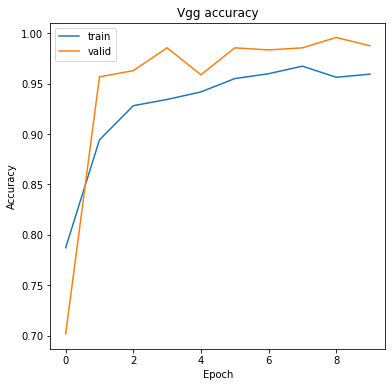

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(train_accuracy_vgg)
plt.plot(valid_accuracy_vgg)
plt.title('Vgg accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
plt.savefig('VGG16_Accuracy.png')

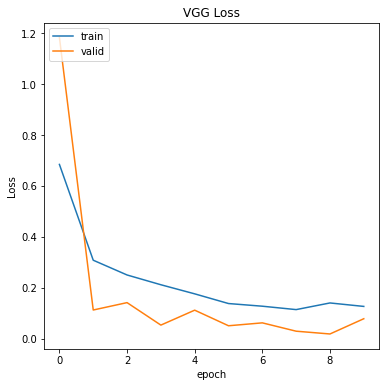

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(train_loss_vgg)
plt.plot(valid_loss_vgg)
plt.title('VGG Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
plt.savefig('VGG_Loss.png')

From the two graphs above we can notice that valid accuracy of the model is  higher than train accuracy, this perhaps is due to Dropout that make our model so good to generalize when see new data.

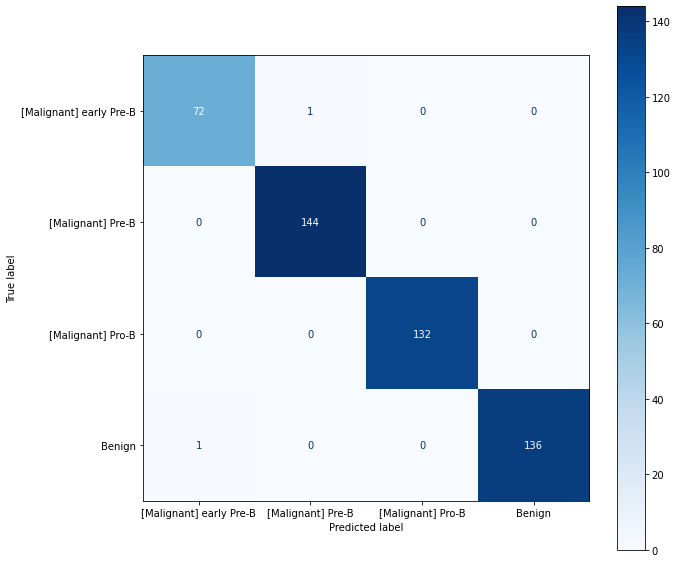

In [ ]:
y_pred_vgg = []
y_true_vgg = []

# iterate over test data
for inputs_vgg, labels_vgg in test_loader:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        inputs_vgg, labels_vgg = inputs_vgg.to(device), labels_vgg.to(device)
        output_vgg = vgg(inputs_vgg) # Feed Network

        output_vgg = (torch.max(torch.exp(output_vgg), 1)[1]).data.cpu().numpy()
        y_pred_vgg.extend(output_vgg) # Save Prediction
        
        labels_vgg = labels_vgg.data.cpu().numpy()
        y_true_vgg.extend(labels_vgg) # Save Truth

# constant for classes
classes = ('[Malignant] early Pre-B', '[Malignant] Pre-B', '[Malignant] Pro-B', 'Benign')

# Build confusion matrix
cf_matrix_vgg = confusion_matrix(y_true_vgg, y_pred_vgg)
cmp_vgg=ConfusionMatrixDisplay(cf_matrix_vgg, display_labels=classes)
fig, ax = plt.subplots(figsize=(10,10))
cmp_vgg.plot(cmap="Blues",ax=ax)
plt.show()

From the confusion matrix we notice that VGG reached a perfect accuracy with very few misclassification.

In [ ]:
print(classification_report(y_true_vgg, y_pred_vgg, target_names=classes))

                         precision    recall  f1-score   support

[Malignant] early Pre-B       0.99      0.99      0.99        73
      [Malignant] Pre-B       0.99      1.00      1.00       144
      [Malignant] Pro-B       1.00      1.00      1.00       132
                 Benign       1.00      0.99      1.00       137

               accuracy                           1.00       486
              macro avg       0.99      0.99      0.99       486
           weighted avg       1.00      1.00      1.00       486

